In [2]:
import pandas as pd 
import re
import os
import string
import csv
import sys
import datetime
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict

In [3]:
tweet_data = pd.read_csv("sentimenttweets.csv")
print(tweet_data.head())

returns_data = pd.read_csv("stocks.csv")
returns_data.head()


  ticker                         created            id  polarity1 sentiment  \
0    MMM  Mon Apr 04 18:53:44 +0000 2022  1.510000e+18   0.106667  positive   
1    MMM  Mon Apr 04 16:55:27 +0000 2022  1.510000e+18   0.000000   neutral   
2    MMM  Mon Apr 04 16:00:46 +0000 2022  1.510000e+18   0.000000   neutral   
3    MMM  Mon Apr 04 14:30:00 +0000 2022  1.510000e+18   0.000000   neutral   
4    MMM  Fri Apr 01 14:48:13 +0000 2022  1.510000e+18   1.000000  positive   

   subjectivity1  polarity2  subjectivity2  
0       0.526667   0.106667       0.526667  
1       0.000000   0.000000       0.000000  
2       0.100000   0.000000       0.000000  
3       0.000000   0.000000       0.000000  
4       0.300000   1.000000       0.300000  


,ticker,change
0,MMM,-0.016707
1,AOS,-0.012981
2,ABT,-0.007476
3,ABBV,-0.001954
4,ABMD,-0.017808


In [4]:
tweet_data['ticker'].nunique()

377

In [5]:
std_target = returns_data['change'].std()
std_target

0.03690740790800519

In [6]:
tweet_agg = tweet_data.groupby(['ticker'],as_index=False).mean()
pd_data = tweet_agg.merge(returns_data)
pd_data

,ticker,id,polarity1,subjectivity1,polarity2,subjectivity2,change
0,A,1.510000e+18,0.137614,0.277176,0.132364,0.272676,-0.016241
1,AAL,1.510000e+18,0.092037,0.243148,0.055926,0.273704,-0.011634
2,AAP,1.510000e+18,0.106667,0.526667,0.106667,0.526667,-0.000425
3,AAPL,1.510000e+18,0.115024,0.333631,0.110274,0.360131,-0.015244
4,ABBV,1.510000e+18,0.287140,0.296502,0.287140,0.285391,-0.001954
...,...,...,...,...,...,...,...
369,YUM,1.510000e+18,0.000000,0.000000,0.000000,0.000000,0.000759
370,ZBH,1.510000e+18,0.000000,0.000000,0.000000,0.000000,-0.000391
371,ZBRA,1.510000e+18,0.000000,0.000000,0.000000,0.000000,0.022238
372,ZION,1.510000e+18,0.000000,0.000000,0.000000,0.000000,-0.028829


In [7]:
pos_data = pd_data[pd_data['polarity2'] != 0]
pd_data.mean()

<ipython-input-7-6b05766f9d27>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pd_data.mean()


id               1.510000e+18
polarity1        1.165467e-01
subjectivity1    2.577170e-01
polarity2        1.101422e-01
subjectivity2    2.584687e-01
change          -1.550989e-02
dtype: float64

In [8]:
def get_sent(row):
    if row[4] > 0:
        val = 'positive'
    elif row[4] < 0:
        val = 'negative'
    else:
        val = 'neutral'
    return val

In [9]:
pd_data['sentiment'] = pd_data.apply(get_sent, axis=1)
pd_data.groupby(['sentiment']).mean()

,id,polarity1,subjectivity1,polarity2,subjectivity2,change
sentiment,,,,,,
negative,1.510000e+18,-0.062723,0.225447,-0.071956,0.223206,-0.020941
neutral,1.510000e+18,0.000410,0.061013,0.000000,0.061013,-0.011511
positive,1.510000e+18,0.174855,0.308528,0.167576,0.309981,-0.015467


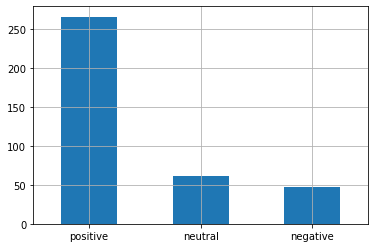

In [10]:
counts = pd_data['sentiment'].value_counts()
counts.plot(kind='bar',rot=360)
plt.grid()

In [11]:
counts[2]

47

# Top 20 results


In [12]:
neg_data = pd_data.sort_values('polarity2').head(10)
pos_data = pd_data.sort_values('polarity2').tail(10)
print(pos_data.groupby(['sentiment']).mean())
print(neg_data.groupby(['sentiment']).mean())

                     id  polarity1  subjectivity1  polarity2  subjectivity2  \
sentiment                                                                     
positive   1.510000e+18   0.656435       0.376907    0.65334       0.372859   

             change  
sentiment            
positive  -0.014029  
                     id  polarity1  subjectivity1  polarity2  subjectivity2  \
sentiment                                                                     
negative   1.510000e+18  -0.178519        0.24463  -0.178519        0.24463   

            change  
sentiment           
negative  -0.01579  


# Splitting Data

In [13]:
target = pd_data['change']
features = pd_data[['polarity2','subjectivity2']]

array([[<AxesSubplot:title={'center':'polarity2'}>,
        <AxesSubplot:title={'center':'subjectivity2'}>]], dtype=object)

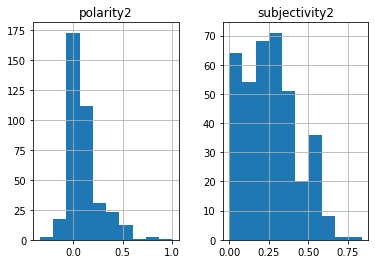

In [14]:
features.hist()

<AxesSubplot:>

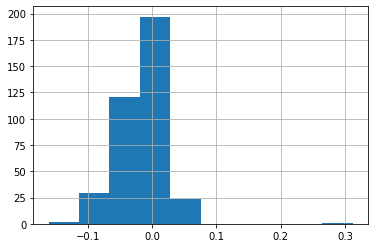

In [15]:
target.hist()

In [16]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state = 0, test_size = 0.2)

# LinearRegressor

In [17]:
lr = LinearRegression()
lr = lr.fit(X_train, y_train)

prediction = lr.predict(X_test)

mse = mean_squared_error(y_test, prediction)
r2 = r2_score(y_test, prediction)

print("\nThe model performance for training set")
print("--------------------------------------")
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(np.sqrt(mse)))
print('R2 is {}'.format(r2))

print("\n")

y_pred = cross_val_predict(LinearRegression(), features, target, cv=5)
mse = mean_squared_error(target, y_pred)
r2 = r2_score(target, y_pred)

print("\nThe model performance for training set")
print("--------------------------------------")
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(np.sqrt(mse)))
print('R2 is {}'.format(r2))

print("\n")


The model performance for training set
--------------------------------------
MSE is 0.0009550571763899632
RMSE is 0.030903999359143845
R2 is -0.002849509995327848



The model performance for training set
--------------------------------------
MSE is 0.0013725925083551357
RMSE is 0.03704851560258705
R2 is -0.017075084915006755




In [18]:
def get_predictions(actual, predict):
    over = 0
    over_num = 0
    under = 0
    under_num = 0
    correct = 0
    for i in range(len(actual)):
        if actual[i] > predict[i]:
            under += 1
            under_num += abs(actual[i] - predict[i])
        elif actual[i] < predict[i]:
            over += 1
            over_num += abs(actual[i] - predict[i])
        else:
            correct += 1
    over_avg = over_num / over
    under_avg = under_num / under
    return (over, over_num, over_avg, under, under_num, under_avg, correct)

In [19]:
def over_under(actual, pred):
    right_neg = 0
    wrong_neg = 0
    right_pos = 0
    wrong_pos = 0
    for i in range(len(actual)):
        if pred[i] < 0 and actual[i] < 0:
            right_neg += 1
        elif pred[i] < 0 and actual[i] > 0:
            wrong_neg += 1
        elif pred[i] > 0 and actual[i] > 0:
            right_pos += 1
        else:
            wrong_pos += 1
            
    return (right_neg, wrong_neg, right_pos, wrong_pos)

In [20]:
std_target = target.std()
std_target

0.03678541749955388

In [21]:
print(len(prediction))
y_test_list = list(y_test)
print(len(y_test_list))

75
75


In [22]:
preds = get_predictions(y_test_list, prediction)
for pred in preds:
    print(pred)

35
0.9733911688805894
0.027811176253731126
40
0.8217639891344772
0.02054409972836193
0


In [23]:
print(len(y_pred))
y_test_list = list(target)
print(len(y_test_list))

374
374


In [24]:
preds = get_predictions(y_test_list, y_pred)
for pred in preds:
    print(pred)

172
4.83240294037709
0.028095365932424943
202
4.833564296513479
0.023928536121353854
0


In [25]:
outcomes = over_under(y_test_list, y_pred)
print('right negative:', outcomes[0])
print('wrong negative:', outcomes[1])
print('right positive:', outcomes[2])
print('wrong positive:', outcomes[3])

right negative: 265
wrong negative: 109
right positive: 0
wrong positive: 0


# KNRegression

In [26]:
# KNN Regression
knn = KNeighborsRegressor()
neighbors = list(range(1,51))

param_grid = dict(n_neighbors = neighbors)
knn_grid = GridSearchCV(knn, param_grid, cv=10)

knn_grid.fit(features, target)
y_pred = list(knn_grid.predict(features))
knn_grid.score(features, target) 
knn_grid.best_params_
mse = mean_squared_error(y_test, prediction)
print(np.sqrt(mse))
print(knn_grid.best_params_) 
print(knn_grid.best_score_)

0.030903999359143845
{'n_neighbors': 50}
-0.07396934184623076


Text(0, 0.5, 'Mean Squared Error')

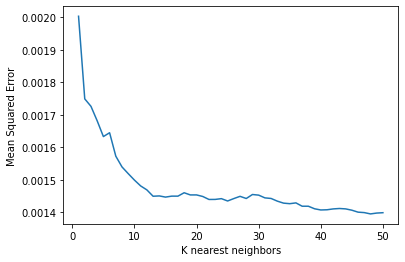

In [27]:
# Graphing the MSE for each hyperparameter
error = []
for k in range(1,51):
    knn = KNeighborsRegressor(n_neighbors=k)
    y_pred = cross_val_predict(knn, features, target, cv=5)
    error.append(mean_squared_error(target,y_pred))
plt.plot(range(1,51),error)
plt.xlabel('K nearest neighbors')
plt.ylabel('Mean Squared Error')

# Random Forest

In [28]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_pred

array([-0.02507161, -0.04637457, -0.01215969, -0.05361161, -0.02120042,
       -0.038589  , -0.00443631, -0.01353022, -0.06175748, -0.00735482,
       -0.05933296, -0.02235618, -0.03073456, -0.01912132,  0.07244117,
       -0.00447037, -0.02777544, -0.02880421, -0.01444491, -0.0105717 ,
       -0.01444491, -0.02043257, -0.01444491, -0.0201811 , -0.01492184,
       -0.04258818, -0.00443631, -0.02903163, -0.02454333, -0.02159666,
       -0.01235705, -0.01215969, -0.01444491, -0.00731175, -0.02043257,
       -0.05361161, -0.0109865 , -0.0385485 , -0.01030003, -0.01215969,
       -0.01999998, -0.02186017,  0.01340174, -0.01453252, -0.00016324,
       -0.00445784, -0.01444491, -0.01215969, -0.01215969, -0.02264002,
        0.00987365, -0.050776  , -0.02128469, -0.00621711, -0.03484381,
       -0.02043257, -0.01215969, -0.01215969, -0.02599254, -0.02845664,
       -0.02120042, -0.01022984, -0.02486192, -0.01215969, -0.01832369,
       -0.01541342,  0.01082461, -0.01215969,  0.00625053, -0.00

In [29]:
mean_squared_error(y_test, y_pred)
np.sqrt(mean_squared_error(y_test, y_pred))

0.03555347899827329

In [30]:
r2 = r2_score(y_test, y_pred)
r2

-0.32730460851385534

In [31]:
RF = RandomForestRegressor(random_state = 0)
search_grid = {'n_estimators': [50 ,100, 150, 200]}
search = GridSearchCV(estimator = RF, param_grid = search_grid, scoring = 'neg_mean_squared_error')
search.fit(X_train, y_train)
print(search.best_params_) 
print(search.best_score_)

{'n_estimators': 100}
-0.0016124400684004903
